In [1]:
import numpy as np
from scipy.linalg import lstsq, pinv, norm
from numpy.random import rand, randn, permutation
import matplotlib.pyplot as plt
%matplotlib inline

Implement an IRLS algorithm for solving sparse regression problems. We are approximately solving 
$\min_{x \in R^D} \left\|x\right\|_{p}$
subject to 
$Ax = b$

When $p = 1$, this optimization is called *basis pursuit*

In [3]:
def BP_irls(A,b,p):
# Solve basis pursuit using IRLS.
# % Inputs:       A is a (N x D) matrix whose rows are the measurement locations         
# %               b is a vector of length N whose values are the measurement values
# %               p is the norm to minimize
# %               
# % Outputs:      xhat is the vector of length D containing the approximate solution
    # algorithm parameters
    eps = 1e-5
    tol = 1e-4
    maxIter = 1000
    xhat = pinv(A)@b

    N, D = A.shape
    xhat = randn(D,1)
    for kk in range(maxIter):
        xprev = xhat
        w = (xhat**2 + eps)**((p-2)/2)
        Winv = np.diag(1/w.squeeze())
        xhat = (Winv@A.T)@lstsq(A@Winv@A.T,b)[0]
        
        # stopping condition
        err = norm(xprev-xhat)/norm(xhat)
        if err < tol:
            break

    return xhat

In [4]:
N = 200
# np.random.seed(1)
# % generate data with outliers
a, b = 10, 5
xx = rand(N,1)
zz = np.zeros((N,1))
k  = N//2
rp = permutation(N)
outlier_subset = rp[:k] 
zz[outlier_subset] = 1

# Data w/ outliers
yy = (1-zz)*(a*xx + b + randn(N,1)) + zz*(20 - 20*xx + 10*randn(N,1))

A = np.append(xx, np.ones((N,1)),axis=1)

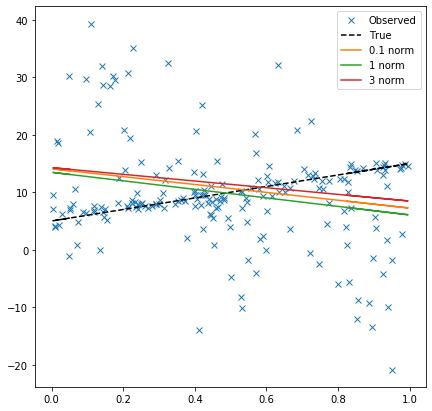

In [5]:
# % plot observed data and true line
plt.figure(figsize=(7,7))
plt.plot(xx,yy,'x',label='Observed')
plt.plot(xx,a*xx + b,'k--',label='True')

# Vary tuning parameter
P = [0.1, 1, 3]
for p in P:
    xhat = BP_irls(A,yy,p)
    plt.plot(xx,xhat[0]*xx + xhat[1],label=str(p)+' norm')
plt.legend();

Implement an ADMM algorithm for solving the LASSO, which is an alternative formulation of the sparse regression problem. ADMM gives a method of solving
\begin{equation*}
    \min_{x \in R^{D}} \frac{1}{2} \left\|Ax - b\right\|_{2}^{2} + \frac{\lambda}{2} \left\|x\right\|_{1}.
\end{equation*}
using the *variable splitting* technique for the update equations.

In [5]:
def st(X,tau):
# Soft-thresholding/shrinkage operator
# % Syntax:       Xs = st(X,tau)
# % Inputs:       X is the input matrix
# %               tau is the input shrinkage parameter
# %
# % Outputs:      Xs is the result of applying soft thresholding to every element in X
    Xs = np.multiply(np.sign(X),np.maximum(0,np.abs(X)-tau))
    return Xs

In [7]:
def lassoADMM(A,b,lam,maxIter=1000):     
# %               lambda is the regularization tuning parameter
# 
# % Outputs:      xhat is the vector of length D containing the approximate solution
    # algorithm parameters
    rho = 10*lam
    tol = 1e-4

    N, D = A.shape
    u = np.zeros((D,1))
    z = np.zeros((D,1))

    Atrans = A.T@A + rho*np.eye(D)
    Abtrans = A.T@b

    for kk in range(maxIter):
        xhat = lstsq(Atrans,Abtrans + rho*(z-u))[0]         
        z = st(xhat + u,lam/rho)
        u = u + xhat - z

        # stopping condition
        err = norm(xhat - z)/norm(xhat)
        if err < tol:
            break

    return xhat

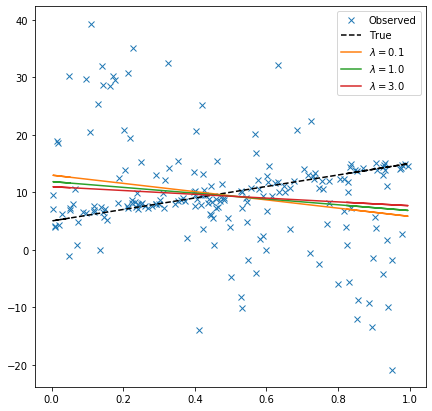

In [10]:
# % plot observed data and true line
plt.figure(figsize=(7,7))
plt.plot(xx,yy,'x',label='Observed')
plt.plot(xx,a*xx + b,'k--',label='True')

# Vary tuning parameter
Lam = [0.1, 1, 3]
for lam in Lam:
    xhat = lassoADMM(A,yy,lam)
    plt.plot(xx,xhat[0]*xx + xhat[1],label='$\lambda = %.1f$'%lam)
plt.legend();

If we want to encourage a different type of behavior than that of a $\ell_{1}$-norm regularizer, we can consider different regularizers. One popular regularizer is called the total variation (TV), which has applications in image denoising and inpainting, and is useful for estimating signals that are known to be piecewise constant

For a signal $w \in R^{D}$, the TV is defined as:
\begin{equation*}
    \text{TV}(w) = \sum_{i = 1}^{D-1} |w_{i+1} - w_{i}|,
\end{equation*}
where $w_{i}$ denotes the $i$th element of $w$. 

If we define a matrix $C$
 \begin{equation}
        C = \begin{bmatrix} -1 & 1 & & \\ & -1 & 1 & \\ & & \ddots & \ddots \\ & & &-1 &1 \end{bmatrix}
    \end{equation}
Then TV becomes $TV(w) =\left\|Cw\right\|_{1}$.

The TV-regularized regression problem can be written as
        \begin{equation}
            \min_{w \in R^{D}} \frac{1}{2} \left\|Xw - y \right\|_{2}^{2} + \lambda \left\|Cw\right\|_{1}
            \label{eq:tvADMM}
        \end{equation}

In [2]:
def diffMat(D):
    # Difference Matrix C for TV regression
    C = -np.eye(D-1)
    C = np.append(C,np.zeros((D-1,1)),axis=1)
    C = C + np.roll(-C,1,1)
    C = np.append(C,np.zeros((1,D)),axis=0)
    return C

In [3]:
def tvADMM(A,b,lam,maxIter=1000):
# Total Variation ADMM
    # algorithm parameters
    rho = 10*lam
    tol = 1e-4
    
    # variable splitting
    N, D = A.shape
    u    = np.zeros((D,1))
    z    = np.zeros((D,1))
    xhat = np.zeros((D,1))

    C = diffMat(D)
    Atrans  = A.T@A + rho*(C.T@C)
    Abtrans = A.T@b

    cost = []

    for kk in range(maxIter):
        x_prev = xhat
        xhat = lstsq(Atrans,Abtrans + rho*C.T@(z-u))[0]   
        z = st(C@xhat + u,lam/rho)
        u = u + C@xhat - z
        # stopping condition
        err = norm(xhat - x_prev,1)/norm(xhat,1)
        cost.append(err)
        if err < tol:
            break

    return xhat, cost

In [6]:
# Generate a piecewise constant signal
# % problem parameters
D = 500
N = 200
sig = 0.5

# % generate data
xtrue = np.zeros((D,1));
xtrue[20:60] = 1;
xtrue[160:200] = 3;
xtrue[200:250] = 5;
xtrue[320:360] = 2;
xtrue[400:430] = 3;

A = randn(N,D);
y = A@xtrue + sig*randn(N,1);
lam = 0.01;
xhat, cost = tvADMM(A,y,lam)

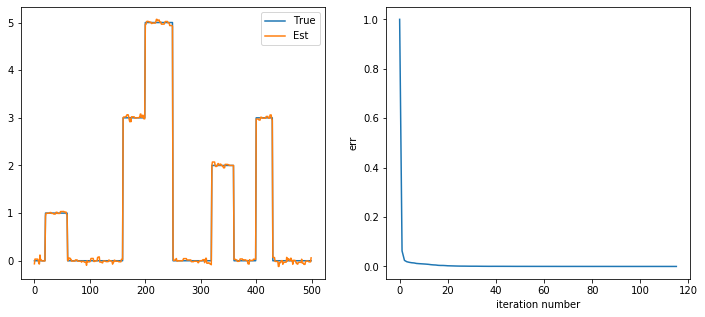

In [15]:
# % plot true line
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(xtrue,label='True')
# Plot tvADMM estimate
plt.plot(xhat,label='Est')
plt.legend();

plt.subplot(122)
# Plot error vs iteration for tvADMM regression
plt.plot(cost)
plt.xlabel('iteration number')
plt.ylabel('err');